In [ ]:
import os
# Define dataset path
train_dir = "/content/drive/MyDrive/FruitinAmazon/train"
# Get class names (subdirectories)
class_names = sorted(os.listdir(train_dir))
if not class_names:
  print("No class directories found in the train folder!")
else:
  print(f"Found {len(class_names)} classes: {class_names}")

Found 6 classes: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']


• Check for Corrupted Images: When working with real world images, occurrences of corrupted
images are common cause of error. Thus we must detect and remove them:
– Open each image and verify if it’s corrupted.
– Store corrupted image paths for review and delete the image from the directory.

In [ ]:
from PIL import Image, UnidentifiedImageError
corrupted_images = [] # List to store corrupted images path
# Loop through each class folder and check for corrupted images
for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path): # Ensure it’s a valid directory
    images = os.listdir(class_path)
    for img_name in images:
      img_path = os.path.join(class_path, img_name)
      try:
        with Image.open(img_path) as img:
          img.verify() # Verify image integrity
      except (IOError, UnidentifiedImageError):
        corrupted_images.append(img_path)

# Print results
if corrupted_images:
  print("\nCorrupted Images Found:")
for img in corrupted_images:
  print(img)
else:
  print("\nNo corrupted images found.")


No corrupted images found.


• Count class Balance: A balanced dataset ensures that no class dominates the model. If some
classes have significantly more images, the model may become biased.
– Count the number of valid images in each class.
– Print and evaluate the class distribution.

In [ ]:
# Dictionary to store class counts
class_counts = {}
for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path):
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
    class_counts[class_name] = len(images) # Count images in each class

# Print Class Balance
print("\nClass Distribution:")
print("=" * 45)
print(f"{'Class Name':<25}{'Valid Image Count':>15}")
print("=" * 45)
for class_name, count in class_counts.items():
  print(f"{class_name:<25}{count:>15}")
  print("=" * 45)


Class Distribution:
Class Name               Valid Image Count
acai                                  15
cupuacu                               15
graviola                              15
guarana                               15
pupunha                               15
tucuma                                15


Select Random Images for Visualization: Visualizing images help verify the dataset is loaded
correctly and if the images are representative of their classes.
– Select one random image from each class.
– Store the selected images for visualization.
– Display randomly selected images in a grid format.

In [ ]:
import random
selected_images = [] # Store image paths
selected_labels = [] # Store corresponding class names
for class_name in class_names:
  class_path = os.path.join(train_dir, class_name)
  if os.path.isdir(class_path):
    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]
  if images: # Ensure the class folder is not empty
    selected_img = os.path.join(class_path, random.choice(images))
    selected_images.append(selected_img)
    selected_labels.append(class_name)

**RANDOM IMAGE PLOT**

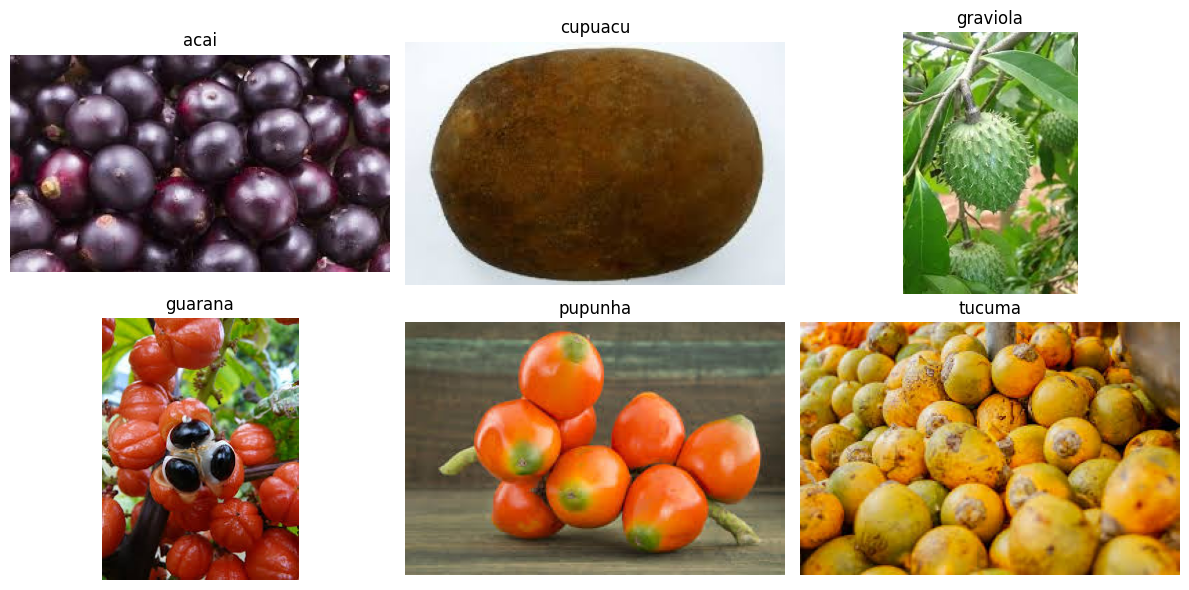

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Determine grid size
num_classes = len(selected_images)
cols = (num_classes + 1) // 2 # Determine columns
rows = 2 # Fixed rows for layout
fig, axes = plt.subplots(rows, cols, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
  if i < num_classes:
    img = mpimg.imread(selected_images[i])
    ax.imshow(img)
    ax.set_title(selected_labels[i])
    ax.axis("off")
else:
  ax.axis("off") # Hide empty subplots
  plt.tight_layout()
  plt.show()

**Data Generation and Pre - processing:**


We use the image dataset from directory {We discussed this last week with detailed description
about its various parameters} utility to generate the datasets, and we use Keras image preprocessing
layers for image standardization and data augmentation. As dataset do not have seperate validation
data, will be using 20% data from train dataset as validation data. For the demonstration further down
I will be using Devnagari Handwritten Digits dataset from week 4.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
image_size = (28, 28)
batch_size = 32
train_ds, val_ds = keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="both",
  seed=1337,
  image_size=image_size,
  batch_size=batch_size,
)

Found 90 files belonging to 6 classes.
Using 72 files for training.
Using 18 files for validation.


**Checking the shape of a batch**

In [ ]:
for images, labels in train_ds.take(1): # Take one batch
  print("Images shape:", images.shape)
  print("Labels shape:", labels.shape)

Images shape: (32, 28, 28, 3)
Labels shape: (32,)


The above training dataset {train ds} can be visualized using:
Visualizing training dataset

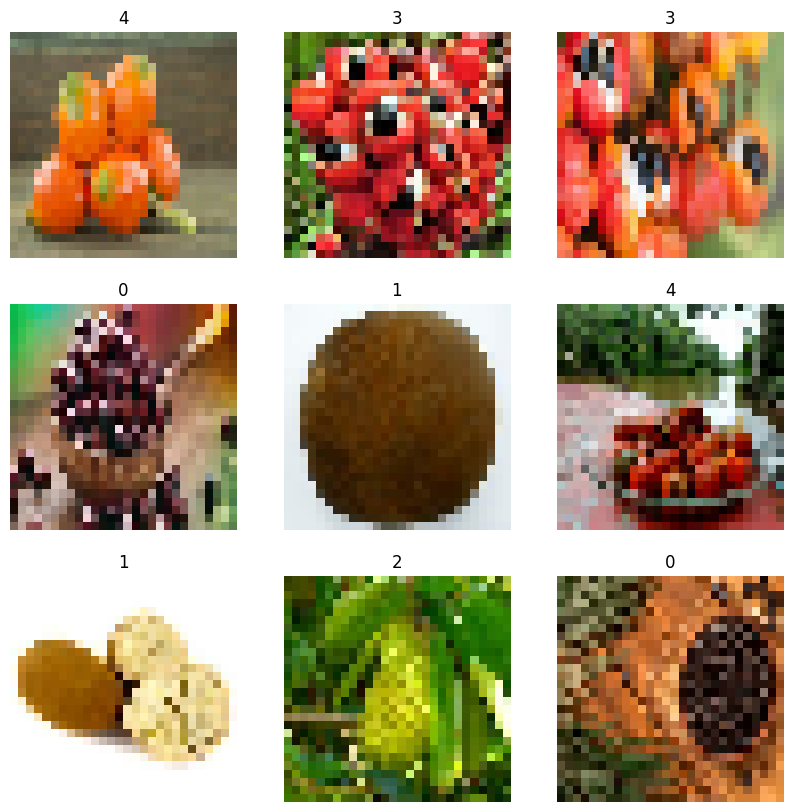

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):#Takes one batch of images from the dataset (train_ds).
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(images[i]).astype("uint8"))
    plt.title(int(labels[i]))
    plt.axis("off")

1. Idea behind Data Augmentation:
Data Augmentation is a technique used in deep learning, especially in computer vision, to artificially
expand a dataset by creating modified versions of images.
• Why use Data Augmentation?
– Prevents Overfitting: Increases dataset diversity without collecting new data.

– Improves Generalization: Helps the model perform better on unseen data.
– Reduces Data Dependency: Useful when collecting large datasets is difficult.
– Makes model more Robust: Introduces real – world variations like lighting changes, rotations,
and distortions.
• Common techniques for Data Augmentations:
1. Geometric Transformations: Some Examples are:
– Flipping: Horizontal or vertical reflection.
– Rotation: Rotating images by small degree.
– Cropping: Randomly selecting a part of the image.
– Scaling: Resizing images while maintaining proportions.
– Translation: Shifting images left, right, up or down.
2. Color Transformations: Some Examples are:
– Brightness Adjustment: Making the image darker or brighter.
– Contrast Change: Increasing or decreasing contrast.
– Noise Addition: Some Examples are:
– Adding random variations in pixel intensity.
3. Occlusion and Information Loss: Some Examples are:
– Cutout: Hiding part of the image to force the model to focus on other details.

2. Data Augmentation with Keras:
Data augmentation in Keras is a technique used to artificially expand the training dataset by applying
random transformations to the existing images. This helps improve model generalization and prevents
overfitting.There are two methods on performing Data Augmentation in Keras:
Using Keras ImageDataGenerator (Old API):
Keras previously used the ImageDataGenerator class to perform real-time augmentation while training.
We can still use this:

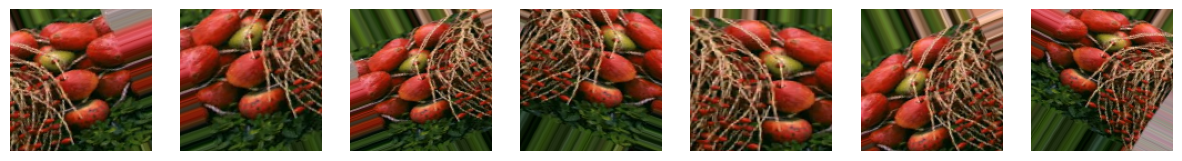

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
  rotation_range=30, # Rotate images by up to 30 degrees
  width_shift_range=0.2, # Shift width by 20%
  height_shift_range=0.2, # Shift height by 20%
  shear_range=0.2, # Shear transformation
  zoom_range=0.2, # Zoom in/out by 20%
  horizontal_flip=True, # Flip images horizontally
  fill_mode='nearest' # Fill in missing pixels
)

# Load an example image
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
img = image.load_img('/content/drive/MyDrive/FruitinAmazon/train/pupunha/images (3).jpeg', target_size=(128, 128))
x = image.img_to_array(img) # Convert to NumPy array
x = np.expand_dims(x, axis=0)
# Generate augmented images
aug_iter = datagen.flow(x, batch_size=1)
# Visualize 7 augmented images
fig, ax = plt.subplots(1, 7, figsize=(15, 5))
for i in range(7):
  batch = next(aug_iter)
  ax[i].imshow(batch[0].astype('uint8'))
  ax[i].axis('off')
plt.show()

Using Keras tf.keras.layers.Random* (New API):
The newer tf.keras.layers API provides augmentation layers that can be directly added to a model.
Thus we expect you to use this for this workshop and your portfolio project.

In [ ]:
# This is a sample implementation, Thus I only use two augmentation, you can use more than twoaugmentation type for your project. Please check keras documentations for other available augmentation techniques.
data_augmentation_layers = [
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
]
def data_augmentation(images):
  for layer in data_augmentation_layers:
    images = layer(images)
  return images

Key difference from ImageDataGenerator:
• Unlike ImageDataGenerator, which operates offline (creating augmented images before training),
these layers are part of the computational graph and applied during training i.e. Can be used
inside a model or independently before training.
• Can be used as part of a TensorFlow model for real-time augmentation on the GPU.

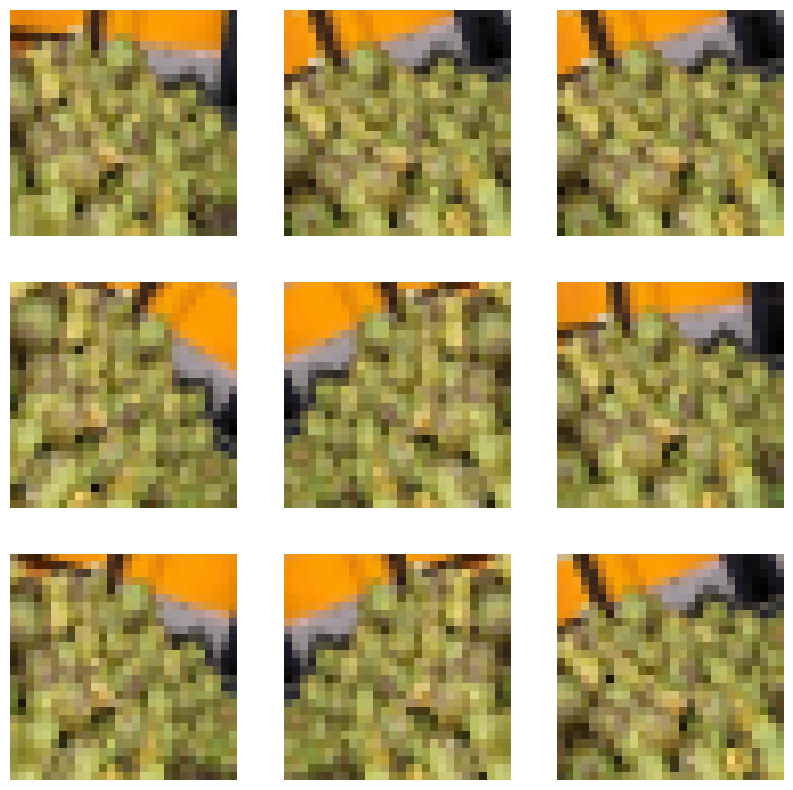

In [ ]:
model = keras.Sequential([
  layers.Input(shape=(128, 128, 3)),
  *data_augmentation_layers, # Include augmentation before the model layers
  layers.Conv2D(32, (3,3), activation="relu"),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(10, activation="softmax")
])

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(np.array(augmented_images[0]).astype("uint8"))
    plt.axis("off")

3. Data Pre - processing: Scaling the data with Keras:
The RGB channel values are in the [0, 255] range. This is not ideal for a neural network; in general
you should seek to make your input values small. Here, we will standardize values to be in the [0, 1] by
using a Rescaling layer at the start of our model. Keras provides two alternated to do this:
1. Applying it to the dataset: Last week, we followed a similar approach. The key change now
is that we will apply data augmentation first, followed by rescaling, ensuring that the augmented
data is also properly rescaled.

In [ ]:
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the correct input shape (example for 224x224 RGB images)
input_shape = (224, 224, 3)  # Adjust based on your dataset

inputs = keras.Input(shape=input_shape)
x = data_augmentation(inputs)  # Make sure data_augmentation is defined
x = layers.Rescaling(1./255)(x)

# ... Continue with the rest of the model
x = layers.Conv2D(32, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(10, activation='softmax')(x)  # Example for 10 classes

model = keras.Model(inputs, outputs)

model.summary()  # Check model architecture

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 394272)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 128)                 │      50,466,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,469,130 (192.52 MB)

 Trainable params: 50,469,130 (192.52 MB)

 Non-trainable params: 0 (0.00 B)

2.3 Model Building:
The sample model from last week:

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize pixel values (0-255 → 0-1) and add channel dimension for Conv2D
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Shape: (60000, 28, 28, 1)
x_test = np.expand_dims(x_test, axis=-1)    # Shape: (10000, 28, 28, 1)

# Define a simple CNN model
model = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),  # Use Input() instead of input_shape in Conv2D
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(10, activation="softmax")  # 10 classes for MNIST digits
])

# Compile the model
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model
model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc:.4f}")

# Make predictions
predictions = model.predict(x_test[:5])
predicted_labels = np.argmax(predictions, axis=1)
print("Predicted labels:", predicted_labels)
print("Actual labels: ", y_test[:5])

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 55s 28ms/step - accuracy: 0.9158 - loss: 0.2842 - val_accuracy: 0.9845 - val_loss: 0.0453
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 52s 28ms/step - accuracy: 0.9870 - loss: 0.0430 - val_accuracy: 0.9877 - val_loss: 0.0385
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 27ms/step - accuracy: 0.9911 - loss: 0.0275 - val_accuracy: 0.9890 - val_loss: 0.0353
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 27ms/step - accuracy: 0.9941 - loss: 0.0182 - val_accuracy: 0.9891 - val_loss: 0.0362
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 26ms/step - accuracy: 0.9958 - loss: 0.0155 - val_accuracy: 0.9915 - val_loss: 0.0267
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9886 - loss: 0.0355
Test accuracy: 0.9915
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Predicted labels: [7 2 1 0 4]
Actual labels:  [7 2 1 0 4]


Batch Normalization Layer
Batch Normalization (BN) is a technique used to improve the training of deep neural networks by
reducing internal covariate shift. It normalizes the output of a previous activation layer by subtracting
the batch mean and dividing by the batch standard deviation. This helps in speeding up training and
improving convergence.
1. BatchNormalization Class in Keras:
The BatchNormalization class in Keras normalizes the activations of the previous layer. It can be applied
to both convolutional and dense layers.

Syntax of BatchNormalization Layer.

In [1]:
from tensorflow.keras.layers import BatchNormalization
layer = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True,
beta_initializer="zeros", gamma_initializer="ones")

In [2]:
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

# Data augmentation layers
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images


# Define the model
model = Sequential([
    layers.Lambda(data_augmentation, input_shape=(224, 224, 3)),
    layers.Rescaling(1./255),

    # First Conv Block
    Conv2D(32, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Second Conv Block
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Third Conv Block
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Fourth Conv Block
    Conv2D(256, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),

    # Fully Connected Layers
    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(128),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    Dense(64),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Output Layer
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model Summary
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             

 Total params: 26,257,930 (100.17 MB)

 Trainable params: 26,255,050 (100.16 MB)

 Non-trainable params: 2,880 (11.25 KB)